In [1]:
from nptdms import TdmsFile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime


path = r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 5\recording 1\Patient 5_1.tdms"
# path = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 6\recording 1\Patient 6_1.tdms"

# path = r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 10\recording 1\Patient 10_1.tdms"


In [2]:
tdms_file = TdmsFile.read(path)
print(tdms_file.properties)
channel1 = tdms_file.groups()[0]
# select EKG channel if present, otherwise take the first channel in the group
channels = channel1.channels()
ecg_channel = next((ch for ch in channels if ch.name.lower() == 'ekg'), channels[0])

# load raw ECG samples as a float numpy array
ecg_raw = ecg_channel.data.astype(float)

# read common waveform properties with safe fallbacks
wf_start = ecg_channel.properties.get('wf_start_time', ecg_channel.properties.get('wf_start', None))
wf_increment = float(ecg_channel.properties.get('wf_increment', ecg_channel.properties.get('wf_val', 0.0)))
wf_samples = int(ecg_channel.properties.get('wf_samples', ecg_raw.shape[0]))

print(f"Channel: {ecg_channel.name}, samples={ecg_raw.shape[0]}, wf_start={wf_start}, wf_increment={wf_increment}")

# # time axis in seconds relative to wf_start
# time_seconds = np.arange(ecg_raw.shape[0]) * wf_increment

# # absolute datetimes for each sample if wf_start is convertible
# try:
#     start_dt = pd.to_datetime(wf_start).to_pydatetime()
#     time_datetimes = [start_dt + datetime.timedelta(seconds=float(s)) for s in time_seconds]
# except Exception:
#     time_datetimes = None

# Print all groups and channels in the TDMS file
for group in tdms_file.groups():
    print(f"Group: {group.name}")
    for channel in group.channels():
        print(f"  Channel: {channel.name}")
        for prop_name, prop_value in channel.properties.items():
            print(f"    Property: {prop_name} = {prop_value}")

OrderedDict({'name': 'Thue Bundgaard 12_10_2016 kl_110502__14_10_2016_ kl_080000.tdms', 'author': 'Jesper', 'description': '', 'registertxt1': 'Written by National Instruments LabVIEW'})
Channel: EKG, samples=82460288, wf_start=2016-10-12T09:05:02.000000, wf_increment=0.001953125
Group: Untitled
  Channel: EKG
    Property: wf_start_time = 2016-10-12T09:05:02.000000
    Property: wf_start_offset = 0.0
    Property: wf_increment = 0.001953125
    Property: wf_samples = 82460288
    Property: DigitalMaximum = 32767
    Property: DigitalMinimum = -32768
    Property: NI_ChannelName = EKG
    Property: NI_ExpIsRelativeTime = False
    Property: wf_time_pref = absolute
    Property: NI_ExpStartTimeStamp = 2016-10-12T09:05:02.000000
    Property: NI_ExpTimeStamp = 2016-10-12T09:05:02.000000
    Property: NI_ExpXDimension = t
    Property: wf_xname = Time
    Property: wf_xunit_string = s
    Property: NI_UnitDescription = uV
    Property: unit_string = uV
    Property: PhysicalMaximum = 9029

In [3]:
from nptdms import TdmsFile
import pandas as pd
import numpy as np
import arrow

def process_tdms_file(tdms_path):
    """
    Process a TDMS file to extract the raw ECG signal and metadata.

    Parameters:
        tdms_path (str): Path to the TDMS file.

    Returns:
        tuple: A tuple containing:
            - ecg_raw (numpy.ndarray): The raw ECG signal as a float numpy array.
            - metadata_df (pandas.DataFrame): A dataframe containing metadata for all channels.
    """

    # Read the TDMS file
    tdms_file = TdmsFile.read(tdms_path)

    # Select the first group and its channels
    channel1 = tdms_file.groups()[0]
    channels = channel1.channels()

    # Select the ECG channel if present, otherwise take the first channel
    ecg_channel = next((ch for ch in channels if ch.name.lower() == 'ekg'), channels[0])

    # Load raw ECG samples as a float numpy array
    ecg_raw = ecg_channel.data.astype(float)

    # Collect metadata for all channels
    metadata = []
    for group in tdms_file.groups():
        for channel in group.channels():
            for prop_name, prop_value in channel.properties.items():
                if prop_name.lower() in ['wf_start_time', 'ni_expisrelativetime', 'ni_exptimestamp']:
                    try:
                        corrected_time = arrow.get(prop_value.astype(datetime.datetime)).to('local')
                        formatted_time = corrected_time.format()
                    except Exception as e:
                        formatted_time = f"Error: {e}"
                    metadata.append({
                        "Group": group.name,
                        "Channel": channel.name,
                        "Property": prop_name,
                        "Value": formatted_time
                    })
                else:
                    metadata.append({
                        "Group": group.name,
                        "Channel": channel.name,
                        "Property": prop_name,
                        "Value": prop_value
                    })

    # Convert metadata to a pandas DataFrame
    metadata_df = pd.DataFrame(metadata)

    return ecg_raw, metadata_df

In [4]:
process_tdms_file(path)

(array([ -70.27081712,   -1.37785916,   37.2021973 , ..., -125.38518349,
        -128.14090181, -125.38518349], shape=(82460288,)),
        Group Channel              Property  \
 0   Untitled     EKG         wf_start_time   
 1   Untitled     EKG       wf_start_offset   
 2   Untitled     EKG          wf_increment   
 3   Untitled     EKG            wf_samples   
 4   Untitled     EKG        DigitalMaximum   
 5   Untitled     EKG        DigitalMinimum   
 6   Untitled     EKG        NI_ChannelName   
 7   Untitled     EKG  NI_ExpIsRelativeTime   
 8   Untitled     EKG          wf_time_pref   
 9   Untitled     EKG  NI_ExpStartTimeStamp   
 10  Untitled     EKG       NI_ExpTimeStamp   
 11  Untitled     EKG      NI_ExpXDimension   
 12  Untitled     EKG              wf_xname   
 13  Untitled     EKG       wf_xunit_string   
 14  Untitled     EKG    NI_UnitDescription   
 15  Untitled     EKG           unit_string   
 16  Untitled     EKG       PhysicalMaximum   
 17  Untitled     EKG 

In [5]:
print(wf_increment)

0.001953125


In [6]:

time1 = [datetime.datetime(2016, 10, 13, 7, 26, 57), datetime.datetime(2016, 10, 13, 7, 26, 31), datetime.datetime(2016, 10, 13, 7, 28, 57), datetime.datetime(2016, 10, 13, 7, 26, 58)]
time2 = [datetime.datetime(2016, 10, 13, 14, 47, 50), datetime.datetime(2016, 10, 13, 14, 47, 29), datetime.datetime(2016, 10, 13, 14, 49, 23), datetime.datetime(2016, 10, 13, 14, 49, 24)]
time3 = [datetime.datetime(2016, 10, 13, 15, 36, 28), datetime.datetime(2016, 10, 13, 15, 36, 30), datetime.datetime(2016, 10, 13, 15, 38, 38), datetime.datetime(2016, 10, 13, 15, 38, 38)]

# time1 = [datetime.datetime(2017, 1, 24, 20, 42, 18), datetime.datetime(2017, 1, 24, 20, 42, 14), datetime.datetime(2017, 1, 24, 20, 44, 22), datetime.datetime(2017, 1, 24, 20, 44, 25)]

# Seizure_times = [time1, time2, time3]

In [7]:
# print(Seizure_times)

In [8]:
import arrow

timestamp = channel.properties['wf_start_time']
local_time = arrow.get(timestamp.astype(datetime.datetime)).to('local')
print(local_time.format())

2016-10-12 10:05:02+01:00


In [9]:
local_time

<Arrow [2016-10-12T10:05:02+01:00]>

In [10]:
print("wf_start as datetime:", pd.to_datetime(wf_start))
print("timestamp as datetime:", pd.to_datetime(timestamp))
print("local time from arrow:", pd.to_datetime(local_time.format()))

wf_start as datetime: 2016-10-12 09:05:02
timestamp as datetime: 2016-10-12 09:05:02
local time from arrow: 2016-10-12 10:05:02+01:00


In [19]:
local_time.datetime

datetime.datetime(2016, 10, 12, 10, 5, 2, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600), 'Rom, normaltid'))

In [13]:
# Flip the calculation: time1 - timestamp

# convert numpy.datetime64 timestamp to Python datetime (overwrites ts_dt if present)
ts_dt = pd.to_datetime(timestamp).to_pydatetime()

# Differences: each datetime in time1 minus the timestamp
diffs_time1_timestamp = [dt - ts_dt for dt in time1]

# Make time1 datetimes timezone-aware in the same timezone as local_time (overwrite if needed)
seizure_time1_arrows = [arrow.get(dt).replace(tzinfo=local_time.tzinfo) for dt in time1]

# Differences: each time1 (as Arrow) minus local_time
diffs_time1_local_time = [s - local_time for s in seizure_time1_arrows]

# Display results
print("timestamp (converted) ->", ts_dt)
print("Differences (time1 - timestamp):")
for i, d in enumerate(diffs_time1_timestamp, 1):
    print(f"  {i}: {d}")

print("\nlocal_time ->", local_time)
print("Differences (time1 treated in same timezone - local_time):")
for i, d in enumerate(diffs_time1_local_time, 1):
    print(f"  {i}: {d}")

timestamp (converted) -> 2016-10-12 09:05:02
Differences (time1 - timestamp):
  1: 22:21:55
  2: 22:21:29
  3: 22:23:55
  4: 22:21:56

local_time -> 2016-10-12T11:05:02+02:00
Differences (time1 treated in same timezone - local_time):
  1: 20:21:55
  2: 20:21:29
  3: 20:23:55
  4: 20:21:56


41223680.0
41285120.0
37537280.0
37598720.0


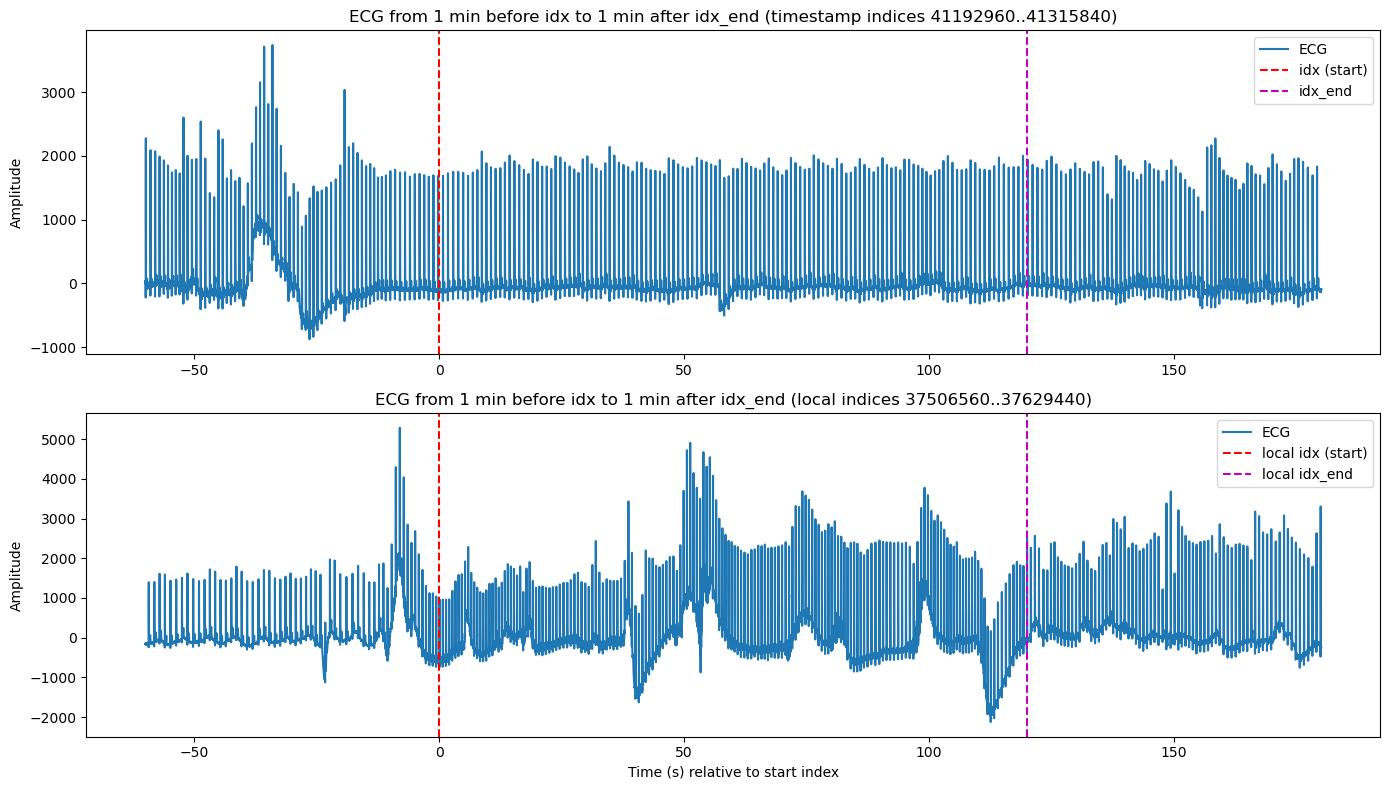

In [14]:
wf_increment = channel.properties['wf_increment']
num_samples = channel.properties['wf_samples']

timestamp_window_idx = diffs_time1_timestamp[0].total_seconds() / wf_increment
print(timestamp_window_idx)
timestamp_window_idx_end = diffs_time1_timestamp[2].total_seconds() / wf_increment
print(timestamp_window_idx_end)
local_time_window_idx = diffs_time1_local_time[0].total_seconds() / wf_increment
print(local_time_window_idx)
local_time_window_idx_end = diffs_time1_local_time[2].total_seconds() / wf_increment
print(local_time_window_idx_end)

# show data from 1 minute before idx to 1 minute after idx_end for both timestamp and local_time spans
pad_seconds = 60
pad_samples = int(round(pad_seconds / wf_increment))

# timestamp-based span
ts_idx = int(round(timestamp_window_idx))
ts_idx_end = int(round(timestamp_window_idx_end))
ts_plot_start = max(0, ts_idx - pad_samples)
ts_plot_end = min(ecg_raw.shape[0], ts_idx_end + pad_samples)
ts_plot_seg = ecg_raw[ts_plot_start:ts_plot_end]
t_ts_plot = (np.arange(ts_plot_start, ts_plot_end) - ts_idx) * wf_increment  # seconds relative to first idx

# local_time-based span
lt_idx = int(round(local_time_window_idx))
lt_idx_end = int(round(local_time_window_idx_end))
lt_plot_start = max(0, lt_idx - pad_samples)
lt_plot_end = min(ecg_raw.shape[0], lt_idx_end + pad_samples)
lt_plot_seg = ecg_raw[lt_plot_start:lt_plot_end]
t_lt_plot = (np.arange(lt_plot_start, lt_plot_end) - lt_idx) * wf_increment  # seconds relative to local idx

plt.figure(figsize=(14, 8))

ax1 = plt.subplot(2, 1, 1)
ax1.plot(t_ts_plot, ts_plot_seg, label='ECG')
# vertical lines at idx (0) and idx_end
ax1.axvline(0, color='r', linestyle='--', label='idx (start)')
ax1.axvline((ts_idx_end - ts_idx) * wf_increment, color='m', linestyle='--', label='idx_end')
ax1.set_title(f'ECG from 1 min before idx to 1 min after idx_end (timestamp indices {ts_plot_start}..{ts_plot_end})')
ax1.set_ylabel('Amplitude')
ax1.legend()

ax2 = plt.subplot(2, 1, 2, sharex=None)
ax2.plot(t_lt_plot, lt_plot_seg, label='ECG')
ax2.axvline(0, color='r', linestyle='--', label='local idx (start)')
ax2.axvline((lt_idx_end - lt_idx) * wf_increment, color='m', linestyle='--', label='local idx_end')
ax2.set_title(f'ECG from 1 min before idx to 1 min after idx_end (local indices {lt_plot_start}..{lt_plot_end})')
ax2.set_xlabel('Time (s) relative to start index')
ax2.set_ylabel('Amplitude')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
import os
# Load through all patient folders
path_patients_folder = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data"
for patient_folder in os.listdir(path_patients_folder):
    patient_path = os.path.join(path_patients_folder, patient_folder)
    if os.path.isdir(patient_path):
        print(f"Processing patient folder: {patient_folder}")
        for recording_folder in os.listdir(patient_path):
            recording_path = os.path.join(patient_path, recording_folder)
            if os.path.isdir(recording_path):
                print(f"  Processing recording folder: {recording_folder}")
                # if folder name contains 'enrollment' (case-insensitive) search one level deeper
                if 'enrollment' in recording_folder.lower() or 'enrollment' in recording_path.lower():
                    for subfolder in os.listdir(recording_path):
                        sub_path = os.path.join(recording_path, subfolder)
                        if os.path.isdir(sub_path):
                            print(f"    Entering enrollment subfolder: {subfolder}")
                            for file_name in os.listdir(sub_path):
                                if file_name.endswith('.tdms'):
                                    file_path = os.path.join(sub_path, file_name)
                                    print(f"      Found TDMS file: {file_name}")
                                    patient_number = file_name.split('_')
                                    print(f"      Patient number extracted: {patient_number[0]}")
                                    # Here you can add code to process each TDMS file as needed
                else:
                    for file_name in os.listdir(recording_path):
                        if file_name.endswith('.tdms'):
                            file_path = os.path.join(recording_path, file_name)
                            print(f"    Found TDMS file: {file_name}")
                            patient_number = file_name.split('_')
                            print(f"    Patient number extracted: {patient_number[0]}")
                            # Here you can add code to process each TDMS file as needed

Processing patient folder: Patient 1
  Processing recording folder: recording 1
    Found TDMS file: Patient 1_1.tdms
    Patient number extracted: Patient 1
  Processing recording folder: recording 2
    Found TDMS file: Patient 1_2.tdms
    Patient number extracted: Patient 1
Processing patient folder: Patient 10
  Processing recording folder: recording 1
    Found TDMS file: Patient 10_1.tdms
    Patient number extracted: Patient 10
Processing patient folder: Patient 11
  Processing recording folder: recording 1
    Found TDMS file: Patient 11_1.tdms
    Patient number extracted: Patient 11
  Processing recording folder: recording 2
    Found TDMS file: Patient 11_2.tdms
    Patient number extracted: Patient 11
Processing patient folder: Patient 12
  Processing recording folder: recording 1
    Found TDMS file: Patient 12_1.tdms
    Patient number extracted: Patient 12
  Processing recording folder: recording 2
    Found TDMS file: Patient 12_2.tdms
    Patient number extracted: Pat

In [13]:
path_seizure_folder = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Seizure log ePatch patients with seizures"



In [14]:
# from ecg_quality.ECGQualityChecker import ECGQualityChecker  

# checker = ECGQualityChecker()
 
# signal = ...	 

# output = checker.process_signal(signal)  

In [15]:
import neurokit2 as nk
ecg_clean = nk.ecg_clean(ecg_raw, sampling_rate=512)

SUMMARY:
Samples compared: 82460288, Sampling rate: 512 Hz
Raw stats: {'min': -90298.0, 'max': 90298.0, 'mean': -1.490538971533526, 'median': -45.46935225451982, 'std': 669.872115567426, 'rms': 669.8737738717684}
Clean stats: {'min': -96238.36804600258, 'max': 96210.71445554294, 'mean': 1.710725212831344e-05, 'median': -48.90918231590812, 'std': 443.774550208032, 'rms': 443.77455020803257}
Noise stats: {'min': -102182.52930817229, 'max': 102811.98795993502, 'mean': -1.4905560787856522, 'median': -4.016669579758322, 'std': 466.4533259157917, 'rms': 466.4557074528376}
MAE: 114.3181, RMSE: 466.4557, Corr: 0.7200, SNR: -0.43 dB


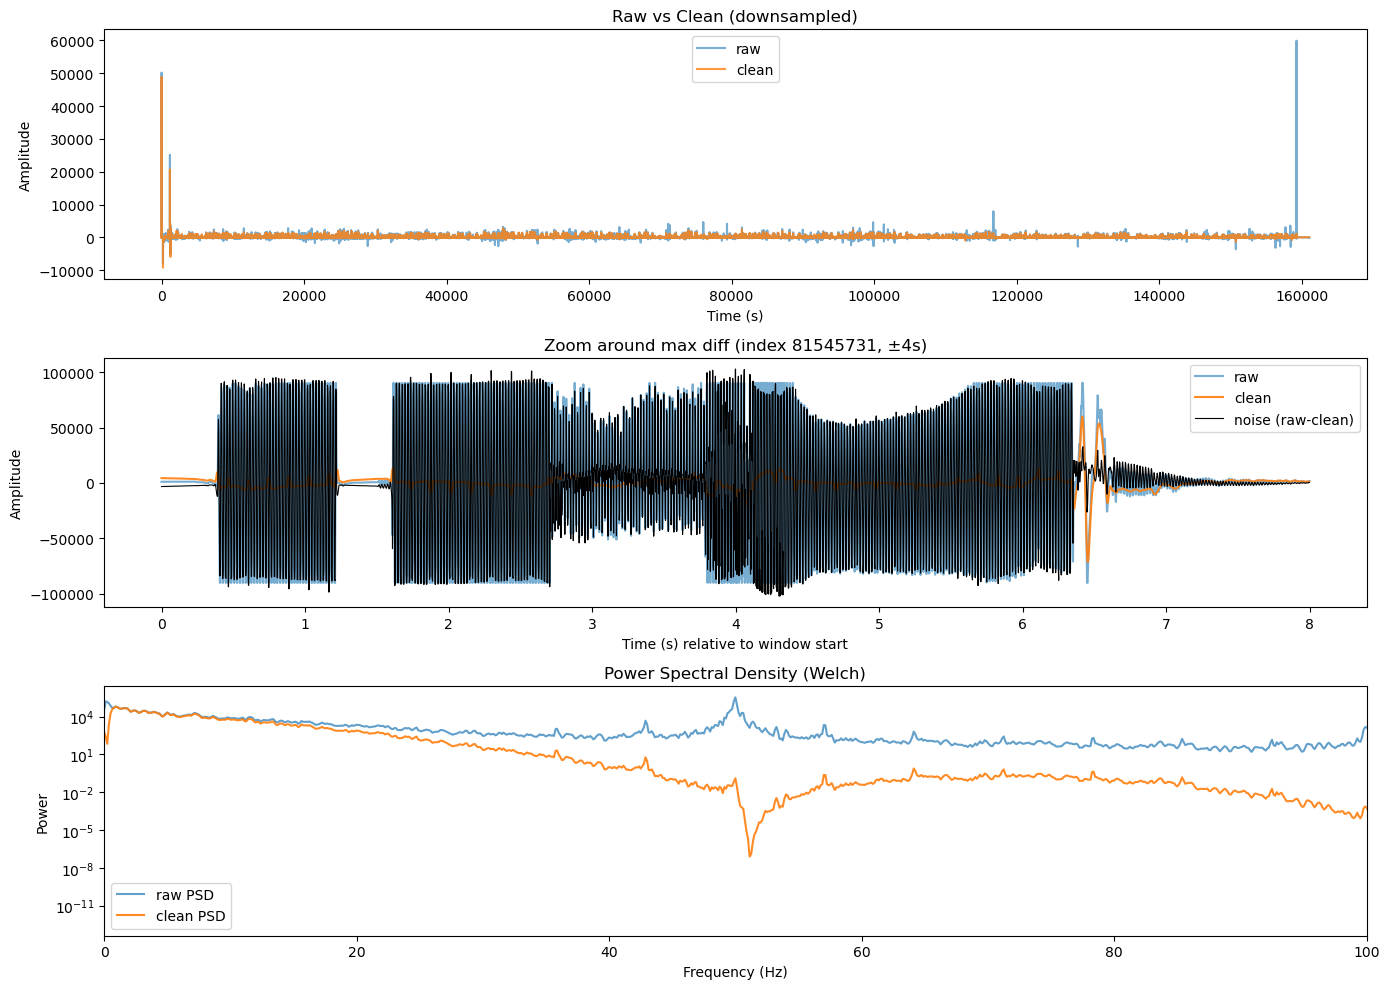

In [16]:
from scipy.signal import welch

# Compare clean and raw ECG signals: statistics, SNR, correlation, PSD and plots.
# Uses existing notebook variables: ecg_raw, ecg_clean, wf_increment, plt, np

# trim to common length
n = min(ecg_raw.shape[0], ecg_clean.shape[0])
raw = ecg_raw[:n].astype(float)
clean = ecg_clean[:n].astype(float)
noise = raw - clean

# sampling
sr = int(round(1.0 / wf_increment)) if wf_increment != 0 else 1
t = np.arange(n) / sr

# basic statistics
def stats(x):
    return {
        "min": float(np.min(x)),
        "max": float(np.max(x)),
        "mean": float(np.mean(x)),
        "median": float(np.median(x)),
        "std": float(np.std(x)),
        "rms": float(np.sqrt(np.mean(x ** 2))),
    }

stats_raw = stats(raw)
stats_clean = stats(clean)
stats_noise = stats(noise)

# error / similarity metrics
mae = float(np.mean(np.abs(noise)))
mse = float(np.mean(noise ** 2))
rmse = float(np.sqrt(mse))
corr = float(np.corrcoef(raw, clean)[0, 1])

# SNR (dB) using clean as signal
p_signal = np.mean(clean ** 2)
p_noise = np.mean(noise ** 2) if np.any(noise) else 1e-12
snr_db = 10.0 * np.log10(p_signal / p_noise)

# PSD (Welch)

nperseg = 4096
f_raw, P_raw = welch(raw, fs=sr, nperseg=nperseg)
f_clean, P_clean = welch(clean, fs=sr, nperseg=nperseg)

# print summary
print("SUMMARY:")
print(f"Samples compared: {n}, Sampling rate: {sr} Hz")
print("Raw stats:", stats_raw)
print("Clean stats:", stats_clean)
print("Noise stats:", stats_noise)
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, Corr: {corr:.4f}, SNR: {snr_db:.2f} dB")

# plotting (downsample for full-length plotting)
max_points = 20000
step = max(1, n // max_points)
idx_ds = np.arange(0, n, step)
t_ds = idx_ds / sr

plt.figure(figsize=(14, 10))

ax1 = plt.subplot(3, 1, 1)
ax1.plot(t_ds, raw[idx_ds], label="raw", alpha=0.6)
ax1.plot(t_ds, clean[idx_ds], label="clean", alpha=0.8)
ax1.set_title("Raw vs Clean (downsampled)")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")
ax1.legend(loc="best")

# zoom around largest discrepancy
idx_max = int(np.argmax(np.abs(noise)))
win_seconds = 4
win_samples = int(win_seconds * sr)
start = max(0, idx_max - win_samples)
end = min(n, idx_max + win_samples)
t_zoom = (np.arange(start, end) - start) / sr

ax2 = plt.subplot(3, 1, 2)
ax2.plot(t_zoom, raw[start:end], label="raw", alpha=0.6)
ax2.plot(t_zoom, clean[start:end], label="clean", alpha=0.9)
ax2.plot(t_zoom, (raw[start:end] - clean[start:end]), label="noise (raw-clean)", color="k", linewidth=0.8)
ax2.set_title(f"Zoom around max diff (index {idx_max}, ±{win_seconds}s)")
ax2.set_xlabel("Time (s) relative to window start")
ax2.set_ylabel("Amplitude")
ax2.legend(loc="best")

# PSD comparison (log scale)
ax3 = plt.subplot(3, 1, 3)
ax3.semilogy(f_raw, P_raw, label="raw PSD", alpha=0.7)
ax3.semilogy(f_clean, P_clean, label="clean PSD", alpha=0.9)
ax3.set_xlim(0, min(100, sr/2))
ax3.set_title("Power Spectral Density (Welch)")
ax3.set_xlabel("Frequency (Hz)")
ax3.set_ylabel("Power")
ax3.legend(loc="best")

plt.tight_layout()
plt.show()

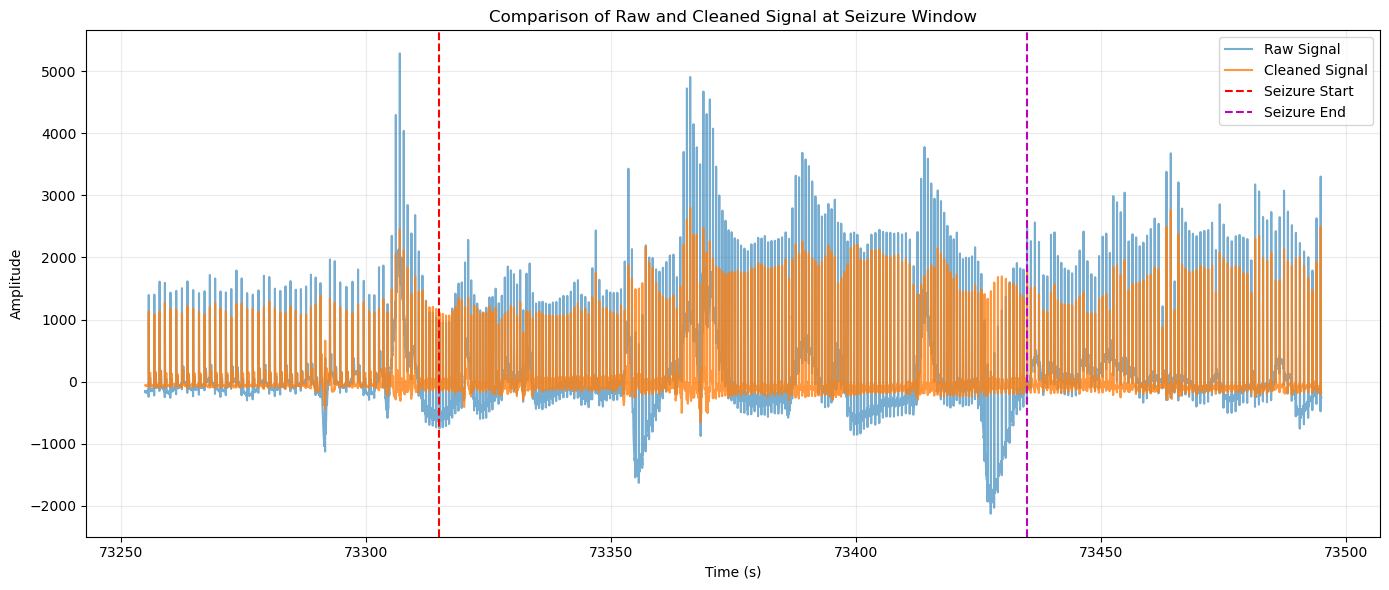

In [37]:
# Extract the raw and cleaned signals for the seizure window
seizure_raw_seg = raw[lt_plot_start:lt_plot_end]
seizure_clean_seg = ecg_clean[lt_plot_start:lt_plot_end]
seizure_time = np.arange(lt_plot_start, lt_plot_end) * wf_increment

# Plot the raw and cleaned signals
plt.figure(figsize=(14, 6))
plt.plot(seizure_time, seizure_raw_seg, label="Raw Signal", alpha=0.6)
plt.plot(seizure_time, seizure_clean_seg, label="Cleaned Signal", alpha=0.8)
plt.axvline(seizure_time[lt_idx - lt_plot_start], color="r", linestyle="--", label="Seizure Start")
plt.axvline(seizure_time[lt_idx_end - lt_plot_start], color="m", linestyle="--", label="Seizure End")
plt.title("Comparison of Raw and Cleaned Signal at Seizure Window")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

In [17]:
pad_seconds_analysis = 60
pad_samples_analysis = int(round(pad_seconds_analysis / wf_increment))
random_idx = 10000000
ecg_clean_analysis = ecg_clean[random_idx:random_idx+pad_samples_analysis]
print(len(ecg_clean_analysis))
ecg_clean_analysis[1000]

30720


np.float64(-65.74830987476086)

In [18]:
import neurokit2 as nk
import pandas as pd
import numpy as np

ecg = ecg_clean_analysis  # din 1D array (30720 punkter ved 512 Hz)

# 1) Processér først
signals, info = nk.ecg_process(ecg, sampling_rate=512)

# (valgfrit) sanity check: er der overhovedet peaks?
n_peaks = int(np.nansum(signals["ECG_R_Peaks"].values))
print(f"Antal fundne R-peaks: {n_peaks}")

if n_peaks < 3:
    raise ValueError("For få R-peaks fundet i vinduet til at køre ecg_analyze() meningsfuldt.")

# 2) Analyser korrekt
res = nk.ecg_analyze(signals, sampling_rate=512)
print(res)


Antal fundne R-peaks: 57
  ECG_Rate_Mean              HRV_MeanNN               HRV_SDNN HRV_SDANN1  \
0      57.19591  [[1050.3627232142858]]  [[97.14547837861264]]    [[nan]]   

  HRV_SDNNI1 HRV_SDANN2 HRV_SDNNI2 HRV_SDANN5 HRV_SDNNI5  \
0    [[nan]]    [[nan]]    [[nan]]    [[nan]]    [[nan]]   

                HRV_RMSSD  ...              HRV_SampEn             HRV_ShanEn  \
0  [[39.225512138872304]]  ...  [[0.9650808960435872]]  [[5.351823225551766]]   

              HRV_FuzzyEn               HRV_MSEn               HRV_CMSEn  \
0  [[0.8504993039986374]]  [[0.693889572284842]]  [[0.6915115769852246]]   

               HRV_RCMSEn                  HRV_CD                 HRV_HFD  \
0  [[0.6865696999623694]]  [[1.7290202159837014]]  [[1.6762120004946657]]   

                  HRV_KFD                 HRV_LZC  
0  [[1.6047347533192269]]  [[0.5185138323265718]]  

[1 rows x 83 columns]


c:\Users\kvjkv\anaconda3\envs\mast\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


In [19]:
signals1, info1 = nk.ecg_peaks(ecg_clean, sampling_rate=512, correct_artifacts=False)

In [20]:
import numpy as np
import pandas as pd

rr_path = r"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results\Patient5_1-corrected-rr.lvm"

# Læs LVM: linje 23 er header -> skiprows=22, header=0 (første linje efter skip er kolonnenavne)
df = pd.read_csv(
    rr_path,
    sep="\t",            # LVM bruger typisk tab
    decimal=",",         # dansk decimalkomma
    engine="python",
    skiprows=22,
    header=0
)

# Trim kolonnenavne for sikkerheds skyld
df.columns = [c.strip() for c in df.columns]

# Primært: brug "Untitled" (2. kolonne med RR)
if "Untitled" in df.columns:
    s = pd.to_numeric(df["Untitled"], errors="coerce")
else:
    # Robust fallback: vælg en numerisk kolonne som IKKE er 'X_Value'/'Comment'
    candidates = [c for c in df.columns if c.lower() not in ("x_value", "xvalue", "comment")]
    s = None
    for c in candidates:
        sc = pd.to_numeric(df[c], errors="coerce")
        # vælg den, der ligner RR i sekunder (median ca. 0.3–2.5 s)
        med = sc.median(skipna=True)
        if sc.notna().mean() > 0.8 and 0.1 < med < 5.0:
            s = sc
            break
    if s is None and len(df.columns) >= 2:
        # absolut sidste udvej: tag 2. kolonne
        s = pd.to_numeric(df.iloc[:, 1], errors="coerce")

# Drop NA
lab_rr = s.dropna().to_numpy(dtype=float)

# Enhedssikring (hvis nogen filer skulle være ms/µs)
med = np.median(lab_rr)
if med > 10000:          # µs -> s
    lab_rr = lab_rr / 1_000_000.0
elif med > 5:            # ms -> s
    lab_rr = lab_rr / 1_000.0

print("lab_rr shape:", lab_rr.shape)
print("lab_rr head (s):", np.round(lab_rr[:5], 6))


lab_rr shape: (186084,)
lab_rr head (s): [0.331858 0.382904 0.167871 0.204339 0.220332]


In [36]:
# Convert RR intervals (lab_rr) to indices with 1's at R peaks
lab_rr_cumsum = np.cumsum(np.insert(lab_rr, 0, 0.0))  # Cumulative sum of RR intervals, starting at 0
lab_rr_indices = np.round(lab_rr_cumsum / wf_increment).astype(int)  # Convert time to sample indices

# Create an array with 1's at R peak indices
lab_rr_peak_indices = np.zeros(wf_samples, dtype=int)  # Initialize array with zeros
lab_rr_peak_indices[lab_rr_indices] = 1  # Set 1's at R peak indices

print("R peak indices array created.")
print(len(lab_rr_peak_indices))

R peak indices array created.
82460288


In [21]:
# Define time difference between local_time and LabView analysis start time
print(signals1.shape)

print(signals1.shape)

dt = datetime.datetime(2016, 10, 12, 11, 6, 19, 181654)
# make dt timezone-aware to match local_time, then compute sample difference using wf_increment
dt_aware = dt.replace(tzinfo=local_time.tzinfo) if dt.tzinfo is None else dt
delta = dt_aware - local_time.datetime
seconds = delta.total_seconds()
samples = seconds / wf_increment if wf_increment != 0 else float('inf')
samples_rounded = int(round(samples))

print("Timedelta:", delta)
print("Seconds difference:", seconds)
print("Sample difference (float):", samples)
print("Sample difference (rounded int):", samples_rounded)
print(dt)

(82460288, 1)
(82460288, 1)
Timedelta: 0:01:17.181654
Seconds difference: 77.181654
Sample difference (float): 39517.006848
Sample difference (rounded int): 39517
2016-10-12 11:06:19.181654


In [22]:
signals1, info1 = nk.ecg_peaks(ecg_clean[samples_rounded:], sampling_rate=512, correct_artifacts=False)

import numpy as np

peaks = info1["ECG_R_Peaks"]              # fx array([949, 1221, 1433, ...])
fs    = info1.get("sampling_rate", 512)    # Hz

# RR-intervaller i sekunder
rr = np.diff(peaks) / fs                  # længde = len(peaks) - 1

rr6 = np.round(rr, 6)                     

print(rr6.shape)

(167138,)


In [23]:

n = min(len(rr6), len(lab_rr))
diff = rr6[:n] - lab_rr[:n]
print("MAE:", np.mean(np.abs(diff)))


MAE: 0.2182217264296569


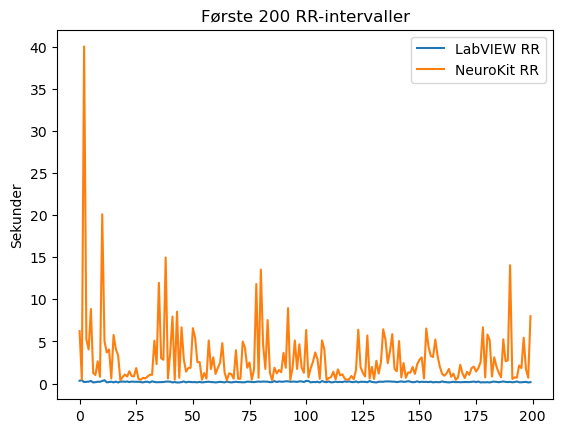

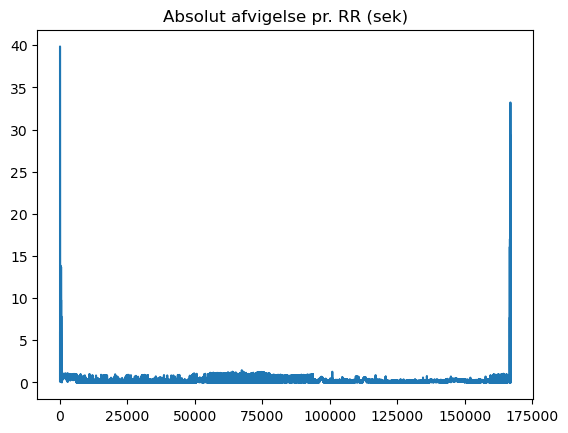

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Sammenlign RR direkte
plt.figure()
plt.plot(lab_rr[:200], label="LabVIEW RR")
plt.plot(rr6[:200], label="NeuroKit RR")
plt.legend()
plt.title("Første 200 RR-intervaller")
plt.ylabel("Sekunder")
plt.show()

# Plot absolut fejl
err = rr6[:len(lab_rr)] - lab_rr[:len(rr6)]
plt.figure()
plt.plot(np.abs(err))
plt.title("Absolut afvigelse pr. RR (sek)")
plt.show()


In [ ]:
# import numpy as np

# peaks = info["ECG_R_Peaks"]
# fs    = info.get("sampling_rate", 512)

# rr_nk = np.diff(peaks) / fs  # sek
# # valgfrit sanity-filter (tilpas hvis nødvendigt)
# mask = (rr_nk > 0.3) & (rr_nk < 2.5)
# rr_nk = rr_nk[mask]


In [ ]:
# t_lab = np.cumsum(np.insert(lab_rr, 0, 0.0))
# t_nk  = np.cumsum(np.insert(rr_nk,  0, 0.0))


In [ ]:
# def match_peaks(tA, tB, tol=0.12):  # 120 ms tolerance er et godt startbud
#     i = j = 0
#     matches = []
#     ins = dels = 0  # insertions (B ekstra), deletions (A mangler)
#     while i < len(tA) and j < len(tB):
#         d = tA[i] - tB[j]
#         if abs(d) <= tol:
#             matches.append((i, j))  # A[i] ↔ B[j]
#             i += 1; j += 1
#         elif d > tol:
#             # B ligger forud -> A mangler et peak (deletion i A)
#             j += 1; dels += 1
#         else:
#             # A ligger forud -> B har et ekstra peak (insertion i A)
#             i += 1; ins += 1
#     # alt resterende er også mismatch
#     ins += max(0, len(tA)-i)
#     dels += max(0, len(tB)-j)
#     return np.array(matches, dtype=int), ins, dels

# matches, ins, dels = match_peaks(t_lab, t_nk, tol=0.12)
# print(f"Matchede beats: {len(matches)} | A-indsættelser: {ins} | A-sletninger: {dels}")


Matchede beats: 54 | A-indsættelser: 186031 | A-sletninger: 3


In [ ]:
# # RR for de matchede positioner (brug +1 for at sammenligne interval EFTER peak)
# iA = matches[:,0] + 1
# iB = matches[:,1] + 1

# # drop matcher, der ikke har et "næste interval"
# mask = (iA < len(lab_rr)) & (iB < len(rr_nk))
# iA = iA[mask]; iB = iB[mask]

# mae_matched = np.mean(np.abs(lab_rr[iA] - rr_nk[iB]))
# print(f"MAE på matchede RR (s): {mae_matched:.6f}")

# # evt. medianfejl som er robust mod outliers
# medae = np.median(np.abs(lab_rr[iA] - rr_nk[iB]))
# print(f"Median absolut fejl (s): {medae:.6f}")


MAE på matchede RR (s): 0.846941
Median absolut fejl (s): 0.878472


In [29]:
print(wf_start)
print(local_time.datetime)

# compute timediff between wf_start (numpy.datetime64) and local_time (arrow.Arrow)

ts_wf = pd.to_datetime(wf_start)                     # naive Timestamp (no tz)
ts_local = pd.to_datetime(local_time.datetime)       # tz-aware Timestamp

# 1) Interpret wf_start as already in the same timezone as local_time (assign that tz)
wf_assigned_local = ts_wf.tz_localize(ts_local.tzinfo)

# 2) Interpret wf_start as UTC and convert to local_time timezone
wf_as_utc = ts_wf.tz_localize('UTC').tz_convert(ts_local.tzinfo)

d_assigned = ts_local - wf_assigned_local
d_utc = ts_local - wf_as_utc

print("wf_start (raw)                 :", ts_wf)
print("local_time                     :", ts_local)
print("wf_start interpreted as local  :", wf_assigned_local)
print("wf_start interpreted as UTC->local :", wf_as_utc)
print()
print(f"Difference (local - wf_assigned_local): {d_assigned}  ({d_assigned.total_seconds()} seconds)")
print(f"Difference (local - wf_as_utc)       : {d_utc}  ({d_utc.total_seconds()} seconds)")

2016-10-12T09:05:02.000000
2016-10-12 11:05:02+02:00
wf_start (raw)                 : 2016-10-12 09:05:02
local_time                     : 2016-10-12 11:05:02+02:00
wf_start interpreted as local  : 2016-10-12 09:05:02+02:00
wf_start interpreted as UTC->local : 2016-10-12 11:05:02+02:00

Difference (local - wf_assigned_local): 0 days 02:00:00  (7200.0 seconds)
Difference (local - wf_as_utc)       : 0 days 00:00:00  (0.0 seconds)


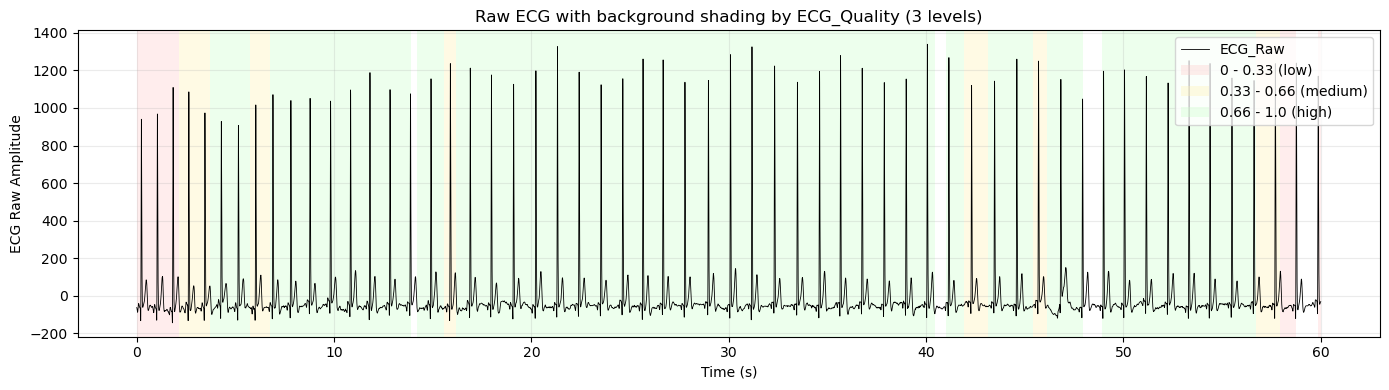

In [30]:
from matplotlib.patches import Patch

# Plot raw ECG with background color bands according to ECG_Quality (3 bins)
# Uses existing variables: signals (DataFrame), q (Series), sr (sampling rate), plt, np

times = np.arange(len(signals)) / sr
ecg_plot = signals["ECG_Raw"].values
quality = signals["ECG_Quality"].values  # same as q but aligned with full window

# Define bins and colors
bins_q = [0.0, 0.33, 0.66, 1.0]
colors = ["#ffcccc", "#fff2b2", "#ccffcc"]  # low: red tint, mid: yellow tint, high: green tint
labels = ["0 - 0.33 (low)", "0.33 - 0.66 (medium)", "0.66 - 1.0 (high)"]

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(times, ecg_plot, color="k", lw=0.6, label="ECG_Raw")

# Shade contiguous regions per quality bin
for i in range(len(bins_q) - 1):
    low, high = bins_q[i], bins_q[i + 1]
    if i < len(bins_q) - 2:
        mask = (quality >= low) & (quality < high)
    else:
        mask = (quality >= low) & (quality <= high)  # include 1.0 in last bin

    idx = np.where(mask)[0]
    if idx.size == 0:
        continue

    # find contiguous runs in idx
    splits = np.where(np.diff(idx) > 1)[0] + 1
    runs = np.split(idx, splits)
    for run in runs:
        start_idx = run[0]
        end_idx = run[-1]
        start_t = start_idx / sr
        end_t = (end_idx + 1) / sr  # make span inclusive
        ax.axvspan(start_t, end_t, facecolor=colors[i], alpha=0.35, edgecolor=None)

# Legend for quality bands
legend_patches = [Patch(facecolor=colors[i], alpha=0.35, label=labels[i]) for i in range(len(labels))]
ax.legend(handles=[ax.lines[0]] + legend_patches, loc="upper right")

ax.set_xlabel("Time (s)")
ax.set_ylabel("ECG Raw Amplitude")
ax.set_title("Raw ECG with background shading by ECG_Quality (3 levels)")
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()

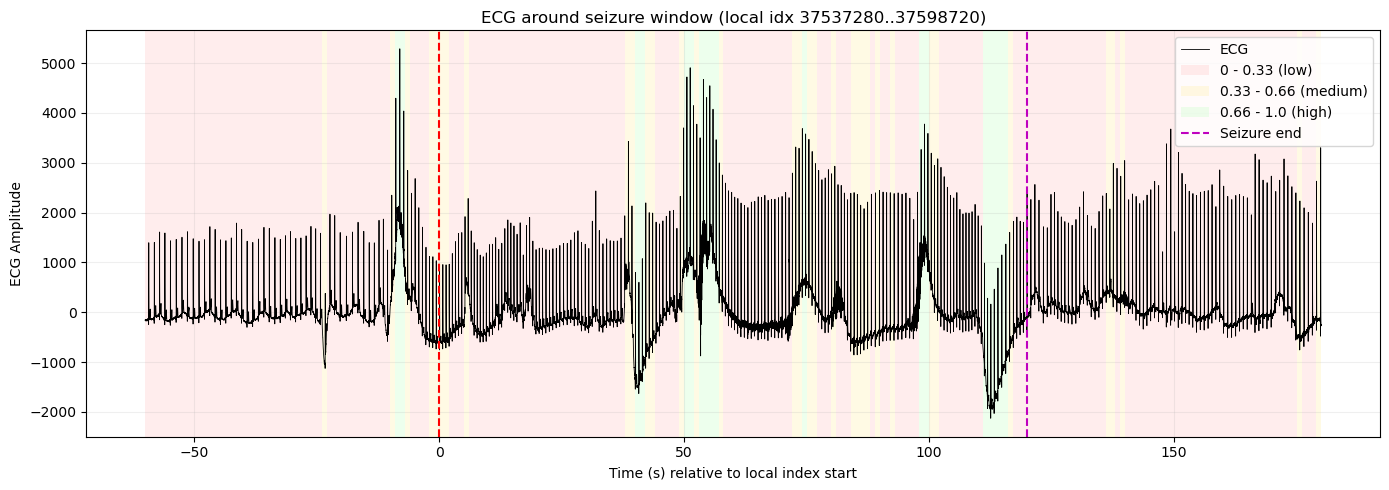

In [31]:
# Plot seizure window (local-time indices lt_idx..lt_idx_end) with quality-colored background.
# Uses existing variables: lt_plot_seg, t_lt_plot, sr, bins_q, colors, labels, wf_increment, lt_idx, lt_idx_end

seg = lt_plot_seg
t = t_lt_plot
assert seg.shape[0] == t.shape[0], "segment and time arrays must match"

# Simple sample-level "quality" estimate: 1-second non-overlapping RMS (normalized 0..1)
win_s = 1.0
win_samples = int(round(win_s * sr)) if sr else 512
if win_samples < 1:
    win_samples = 1

# pad to full windows
n = seg.shape[0]
pad = (win_samples - (n % win_samples)) % win_samples
seg_p = np.pad(seg, (0, pad), mode="constant", constant_values=(0.0,))
seg_reshaped = seg_p.reshape(-1, win_samples)

rms_windows = np.sqrt(np.mean(seg_reshaped.astype(float) ** 2, axis=1))
# normalize to 0..1 (robust: clip)
rmin, rmax = np.nanpercentile(rms_windows, 5), np.nanpercentile(rms_windows, 95)
if rmax - rmin <= 1e-12:
    q_windows = np.clip((rms_windows - rmin), 0, None)
else:
    q_windows = (rms_windows - rmin) / (rmax - rmin)
q_windows = np.clip(q_windows, 0.0, 1.0)

# expand back to sample-level quality (trim padding)
quality_samples = np.repeat(q_windows, win_samples)[:n]

# Use existing bins_q, colors, labels if present; else fallback
try:
    _bins = np.array(bins_q)
    _colors = colors
    _labels = labels
except Exception:
    _bins = np.array([0.0, 0.33, 0.66, 1.0])
    _colors = ["#ffcccc", "#fff2b2", "#ccffcc"]
    _labels = ["0 - 0.33 (low)", "0.33 - 0.66 (medium)", "0.66 - 1.0 (high)"]

# Make plot
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(t, seg, color="k", lw=0.6, label="ECG")

# Shade contiguous regions per quality bin
for i in range(len(_bins) - 1):
    low, high = _bins[i], _bins[i + 1]
    if i < len(_bins) - 2:
        mask = (quality_samples >= low) & (quality_samples < high)
    else:
        mask = (quality_samples >= low) & (quality_samples <= high)

    idx = np.where(mask)[0]
    if idx.size == 0:
        continue

    # find contiguous runs
    splits = np.where(np.diff(idx) > 1)[0] + 1
    runs = np.split(idx, splits)
    for run in runs:
        start_idx = run[0]
        end_idx = run[-1]
        start_t = t[start_idx]
        end_t = t[end_idx] + (1.0 / sr)  # inclusive end
        ax.axvspan(start_t, end_t, facecolor=_colors[i], alpha=0.35, edgecolor=None)

# Seizure event vertical lines (start at t=0 relative to lt_idx)
seizure_start_s = 0.0
seizure_end_s = (lt_idx_end - lt_idx) * wf_increment
ax.axvline(seizure_start_s, color="r", linestyle="--", linewidth=1.5, label="Seizure start")
ax.axvline(seizure_end_s, color="m", linestyle="--", linewidth=1.5, label="Seizure end")

ax.set_xlabel("Time (s) relative to local index start")
ax.set_ylabel("ECG Amplitude")
ax.set_title(f"ECG around seizure window (local idx {lt_idx}..{lt_idx_end})")
# Legend: ECG line + quality band patches
from matplotlib.patches import Patch as _Patch  # Patch already imported earlier, safe to alias
patches = [_Patch(facecolor=_colors[i], alpha=0.35, label=_labels[i]) for i in range(len(_labels))]
ax.legend(handles=[ax.lines[0]] + patches + [ax.lines[-1]], loc="upper right")

ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()

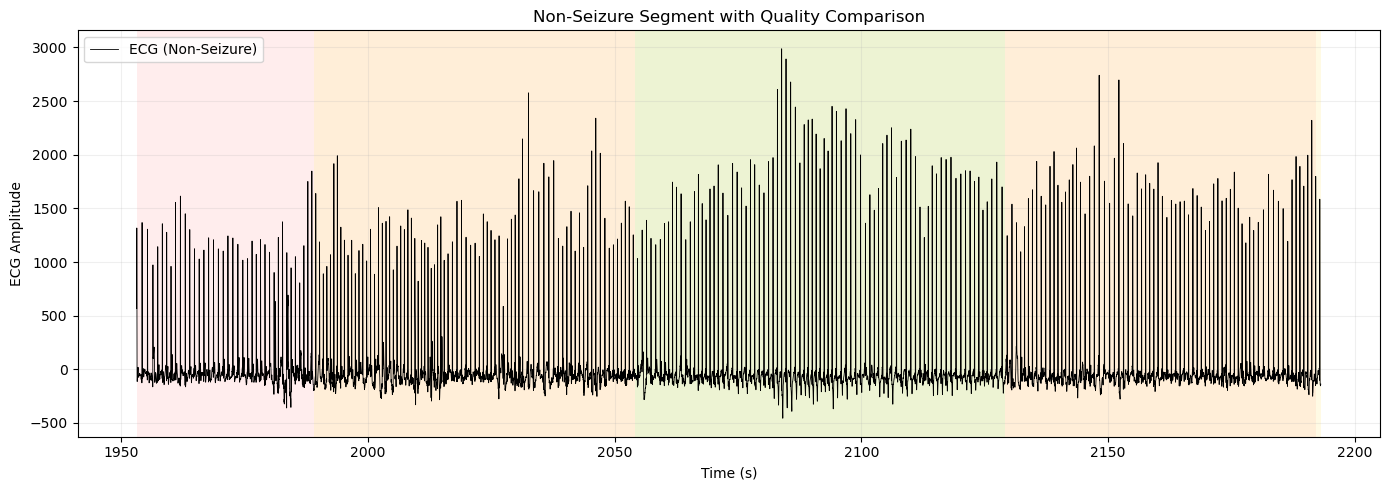

In [34]:
# Define a random segment outside the seizure window
non_seizure_start_idx = 1000000  # Example start index far from seizure
non_seizure_end_idx = non_seizure_start_idx + lt_plot_seg.shape[0]

# Extract the non-seizure segment
non_seizure_seg = ecg_clean[non_seizure_start_idx:non_seizure_end_idx]
non_seizure_t = np.arange(non_seizure_start_idx, non_seizure_end_idx) * wf_increment

# Plot the non-seizure segment with quality comparison
plt.figure(figsize=(14, 5))
plt.plot(non_seizure_t, non_seizure_seg, color="k", lw=0.6, label="ECG (Non-Seizure)")

# Add quality shading (if applicable)
if "quality_samples" in locals():
    non_seizure_quality = quality_samples[:non_seizure_seg.shape[0]]
    for i in range(len(bins_q) - 1):
        low, high = bins_q[i], bins_q[i + 1]
        mask = (non_seizure_quality >= low) & (non_seizure_quality < high)
        idx = np.where(mask)[0]
        if idx.size > 0:
            plt.axvspan(non_seizure_t[idx[0]], non_seizure_t[idx[-1]], facecolor=colors[i], alpha=0.35)

plt.xlabel("Time (s)")
plt.ylabel("ECG Amplitude")
plt.title("Non-Seizure Segment with Quality Comparison")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

In [32]:
print(res.columns)

Index(['ECG_Rate_Mean', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1',
       'HRV_SDANN2', 'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD',
       'HRV_SDSD', 'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN',
       'HRV_MCVNN', 'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN',
       'HRV_pNN50', 'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI',
       'HRV_TINN', 'HRV_ULF', 'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_VHF',
       'HRV_TP', 'HRV_LFHF', 'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'HRV_SD1',
       'HRV_SD2', 'HRV_SD1SD2', 'HRV_S', 'HRV_CSI', 'HRV_CVI',
       'HRV_CSI_Modified', 'HRV_PIP', 'HRV_IALS', 'HRV_PSS', 'HRV_PAS',
       'HRV_GI', 'HRV_SI', 'HRV_AI', 'HRV_PI', 'HRV_C1d', 'HRV_C1a',
       'HRV_SD1d', 'HRV_SD1a', 'HRV_C2d', 'HRV_C2a', 'HRV_SD2d', 'HRV_SD2a',
       'HRV_Cd', 'HRV_Ca', 'HRV_SDNNd', 'HRV_SDNNa', 'HRV_DFA_alpha1',
       'HRV_MFDFA_alpha1_Width', 'HRV_MFDFA_alpha1_Peak',
       'HRV_MFDFA_alpha1_Mean', 'HRV_MFDFA_alpha1_Max',
       'HRV_MF

In [33]:
# # Safely run ecg_analyze and fall back to processing first if it raises UnboundLocalError.
# # Use existing sampling rate variable `sr` (512) if present.
# _sampling_rate = globals().get("sr", 512)

# try:
# 	analysis_res = nk.ecg.ecg_analyze(ecg_clean, sampling_rate=_sampling_rate, method="auto")
# except UnboundLocalError:
# 	# Some neurokit versions may raise UnboundLocalError inside ecg_analyze when peaks aren't found.
# 	# First try to preprocess the signal, then analyze the processed output.
# 	try:
# 		processed = nk.ecg_process(ecg_clean, sampling_rate=_sampling_rate)
# 		# nk.ecg_process returns (signals, info) in many versions
# 		if isinstance(processed, tuple) and len(processed) == 2:
# 			signals, info = processed
# 		else:
# 			signals = processed
# 		analysis_res = nk.ecg.ecg_analyze(signals, sampling_rate=_sampling_rate, method="auto")
# 	except Exception as e:
# 		# final fallback: return empty dict and print error for debugging
# 		print("ecg_analyze failed after preprocessing:", repr(e))
# 		analysis_res = {}

In [44]:
print(quality_samples.shape)
print(bins_q)

(122880,)
[0.0, 0.33, 0.66, 1.0]


In [41]:
# Calculate the percentage of the signal in each quality bin
bin_percentages = []
for i in range(len(bins_q) - 1):
    low, high = bins_q[i], bins_q[i + 1]
    if i < len(bins_q) - 2:
        mask = (quality_samples >= low) & (quality_samples < high)
    else:
        mask = (quality_samples >= low) & (quality_samples <= high)  # include 1.0 in the last bin
    bin_percentage = np.sum(mask) / len(quality_samples) * 100
    bin_percentages.append(bin_percentage)

# Display the results
for i, percentage in enumerate(bin_percentages):
    print(f"Quality bin '{labels[i]}': {percentage:.2f}%")

Quality bin '0 - 0.33 (low)': 78.33%
Quality bin '0.33 - 0.66 (medium)': 14.17%
Quality bin '0.66 - 1.0 (high)': 7.50%


In [5]:
# Test new TDMS loaders

from src.hrv_epatch.io.tdms import load_tdms_from_path

tdms_path = r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 5\recording 1\Patient 5_1.tdms"
sig, meta = load_tdms_from_path(
    tdms_path,
    channel_hint="EKG",
    prefer_tz="Europe/Copenhagen",
    assume_source_tz="UTC",       # eller None, hvis TDMS allerede er lokal tid
)

print(meta.start_time, meta.fs)
print(sig.shape)
print(meta.n_samples)


2016-10-12 11:05:02 512.0
(82460288,)
82460288


In [6]:
from src.hrv_epatch.io.tdms import build_ecg_dataframe

ecg_df = build_ecg_dataframe(sig, meta)

print(ecg_df.head())
print(ecg_df.shape)

                      Timestamp       Value
0 2016-10-12 11:05:02.000000000  -70.270817
1 2016-10-12 11:05:02.001953125   -1.377859
2 2016-10-12 11:05:02.003906250   37.202197
3 2016-10-12 11:05:02.005859375  -45.469352
4 2016-10-12 11:05:02.007812500 -144.675212
(82460288, 2)


In [7]:
from src.hrv_epatch.io.tdms import load_tdms_for_patient

BASE_DIR = r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne"

sig, meta = load_tdms_for_patient(
    "Patient 5",
    base_dir=BASE_DIR,
    channel_hint="EKG",
)

print(meta.start_time, meta.fs)
print(sig.shape)
print(meta.n_samples)


2016-10-12 11:05:02 512.0
(82460288,)
82460288


In [8]:
from src.hrv_epatch.io.data_loader import Load_full_ecg_data

res = Load_full_ecg_data("Patient 5")

print("Patient:", res["PatientID"])
print("fs:", res["SampleRate"])
print("Start:", res["StartTime"])
print("TDMS path:", res["TdmsPath"])
print(res["ECG"].head())
print(res["Seizures"].head())


Patient: Patient 5
fs: 512.0
Start: 2016-10-12 11:05:02
TDMS path: E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 5\recording 1\Patient 5_1.tdms
                      Timestamp       Value
0 2016-10-12 11:05:02.000000000  -70.270817
1 2016-10-12 11:05:02.001953125   -1.377859
2 2016-10-12 11:05:02.003906250   37.202197
3 2016-10-12 11:05:02.005859375  -45.469352
4 2016-10-12 11:05:02.007812500 -144.675212
0  NaN Anfald nr.      Dato Anfaldsstart Klinisk (tt:mm:ss)  \
0  NaN          1  13.10.16                        07:26:57   
1  NaN          2  13.10.16                        14:47:50   
2  NaN          3  13.10.16                        15:36:28   

0 Anfaldsstart EEG (tt:mm:ss) Anfaldstop Klinisk (tt:mm:ss)  \
0                    07:26:31                      07:28:57   
1                    14:47:29                      14:49:23   
2                    15:36:30                      15:38:38   

0 Anfaldstop EEG (tt:mm